In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt


In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')

347 total WT RuBisCOs
286 total unique species
200 RuBisCOs with all core kinetic data measured


In [4]:
# vC vs S
vCs = np.log(raw_kin_df.vC)
Ss = np.log(raw_kin_df.S)

print('Whole dataset correlation')
slope, intercept, r, p, stderr = power_laws.log_linregress(Ss, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(Ss, vCs))

fIs = raw_kin_df[raw_kin_df.isoform == '1']
vCs = np.log(fIs.vC)
Ss = np.log(fIs.S)

print('FI dataset correlation')
slope, intercept, r, p, stderr = power_laws.log_linregress(Ss, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(Ss, vCs))

vCs = np.log(savir_df.vC)
Ss = np.log(savir_df.S)

print('Savir correlation')
slope, intercept, r, p, stderr = power_laws.log_linregress(Ss, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(Ss, vCs))

Whole dataset correlation
Log-scale linear regression R = 0.01, P = 0.94
Spearman rank correlation R = -0.31, P = 1.5e-06
FI dataset correlation
Log-scale linear regression R = -0.59, P = 1.7e-22
Spearman rank correlation R = -0.34, P = 1.2e-07
Savir correlation
Log-scale linear regression R = -0.71, P = 0.00072
Spearman rank correlation R = -0.88, P = 4.8e-07


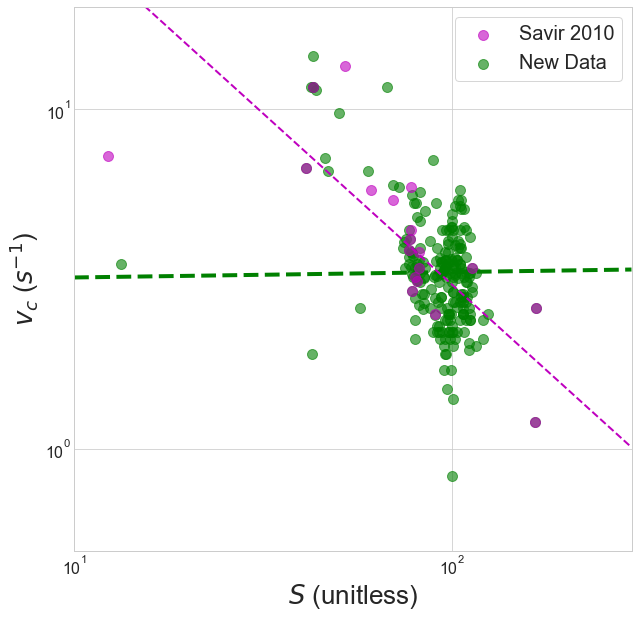

In [5]:
# Central correlation of Tcherkez2006 is S vs vC. 
# Plot data from Savir separate from new data.

# S vs. vC correlation for all data rubiscos
Ss = np.log(raw_kin_df.S)
vCs = np.log(raw_kin_df.vC)
exponent, prefactor, r2 = power_laws.fit_power_law_odr(Ss, vCs)

# S vs. vC correlation for all data rubiscos
Ss_savir = np.log(savir_df.S)
vCs_savir = np.log(savir_df.vC)
exp_sav, pre_sav, r2_sav = power_laws.fit_power_law_odr(Ss_savir, vCs_savir)

figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

# loglog scale
plt.xscale('log')
plt.yscale('log')

# Note - axes are reversed from the Savir paper so above the line = good.
plt.scatter(savir_df.S, savir_df.vC, c='m', s=100, label='Savir 2010', alpha=0.6, zorder=10)
plt.scatter(nonsavir_df.S, nonsavir_df.vC, c='g', s=100, label='New Data', alpha=0.6, zorder=1)

# Plot regression of S vs vC
xs = np.arange(10, 300, 1)
predicted_ys = np.power(xs, exponent) * prefactor
plt.plot(xs, predicted_ys, ls='--', c='g', lw=4)

predicted_ys_sav = np.power(xs, exp_sav) * pre_sav
plt.plot(xs, predicted_ys_sav, ls='--', c='m', lw=2)

plt.legend(loc=1, fontsize=20, frameon=True)
plt.xlabel('$S$ (unitless)', fontsize=26)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(10, 300)
plt.ylim(5e-1, 20)

plt.savefig('fig3/fig3_vC_S_corr.svg')
plt.savefig('fig3/fig3_vC_S_corr.png', dpi=600)

plt.show()

In [6]:
all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
exps, pres, rs = power_laws.bootstrap_power_law_odr(
    all_FIs.S, all_FIs.vC, xs_std=all_FIs.S_SD, ys_std=all_FIs.vC_SD,
    fraction=0.9, rounds=10000)

conf_range = [2.5, 97.5]
pre_interval = np.percentile(pres, conf_range)
exp_interval = np.percentile(exps, conf_range)
rs_interval = np.percentile(rs, conf_range)

print(exp_interval)
print(pre_interval)
print(rs_interval)
print()

/usr/local/lib/python3.6/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/Users/abrahamflamholz/Documents/workspace/rubisco/notebooks/power_laws.py:131: RuntimeWarning: invalid value encountered in log
  exp, pre, r = fit_power_law_odr(np.log(xs_sub), np.log(ys_sub))


[-3.48218909 -1.9970406 ]
[   27213.82697305 22590930.16808693]
[0.41095667 0.73344152]



[   27213.82697305 22590930.16808693]
[-3.48218909 -1.9970406 ]


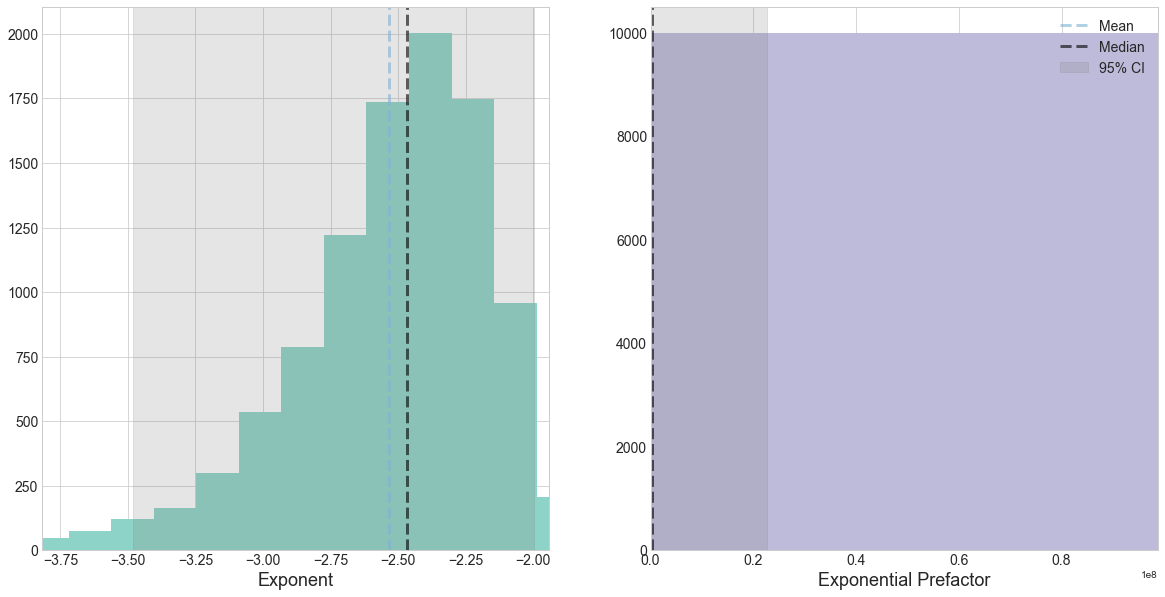

In [7]:
power_laws.plot_bootstrapped_range(exps, pres)

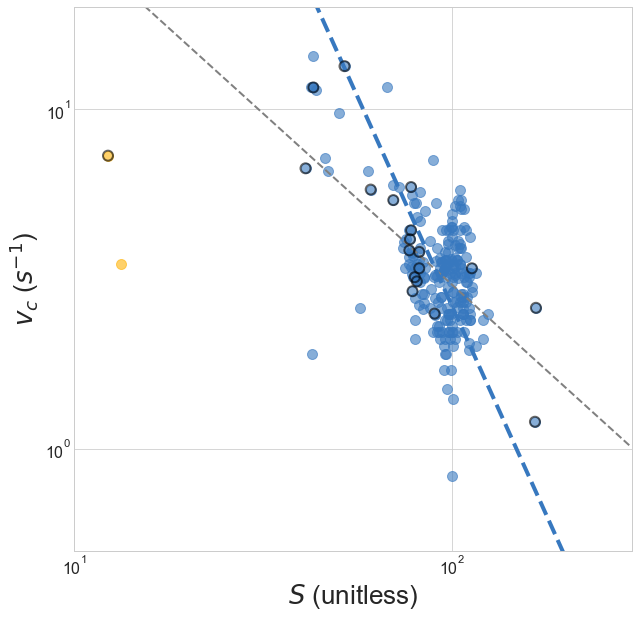

In [8]:
# Plot S vs. Vc coloring by RuBisCO form.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
    label = 'Form %s' % groups[group]
    c = named_colors[i]
    plt.scatter(gdf.S, gdf.vC, c=c, s=100, label=label, alpha=0.6)

xs = np.arange(10, 300, 1)
predicted_ys_sav = np.power(xs, exp_sav) * pre_sav
plt.plot(xs, predicted_ys_sav, ls='--', c='grey', lw=2)

# Plot regression of S vs vC
all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
c = matplotlib.colors.rgb2hex(named_colors[0])
power_laws.plot_bootstrapped_ci(xs, exps, pres, figure=figure, color=c, plot_range=False, lw=4)

# Show savir data with an outline
plt.scatter(savir_df.S, savir_df.vC, c='None', edgecolors='k',
            linewidths=2, s=100, label='Savir 2010', alpha=0.6, zorder=10)

#plt.legend(loc=1, fontsize=18, frameon=True)
plt.xlabel('$S$ (unitless)', fontsize=26)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(10, 300)
plt.ylim(5e-1, 20)

plt.savefig('fig3/fig3_vC_S_corr_FI.svg')
plt.savefig('fig3/fig3_vC_S_corr_FI.png', dpi=600)

plt.show()

In [9]:
# vC vs KC
vCs = np.log(raw_kin_df.vC)
KCs = np.log(raw_kin_df.KC)

print('Whole dataset correlation')
slope, intercept, r, p, stderr = power_laws.log_linregress(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))

fIs = raw_kin_df[raw_kin_df.isoform == '1']
vCs = np.log(fIs.vC)
KCs = np.log(fIs.KC)

print('FI dataset correlation')
slope, intercept, r, p, stderr = power_laws.log_linregress(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))

vCs = np.log(savir_df.vC)
KCs = np.log(savir_df.KC)

print('Savir correlation')
slope, intercept, r, p, stderr = power_laws.log_linregress(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))

Whole dataset correlation
Log-scale linear regression R = 0.47, P = 6.6e-16
Spearman rank correlation R = 0.51, P = 2e-18
FI dataset correlation
Log-scale linear regression R = 0.62, P = 2.4e-28
Spearman rank correlation R = 0.54, P = 2.5e-20
Savir correlation
Log-scale linear regression R = 0.92, P = 2.9e-08
Spearman rank correlation R = 0.86, P = 2e-06


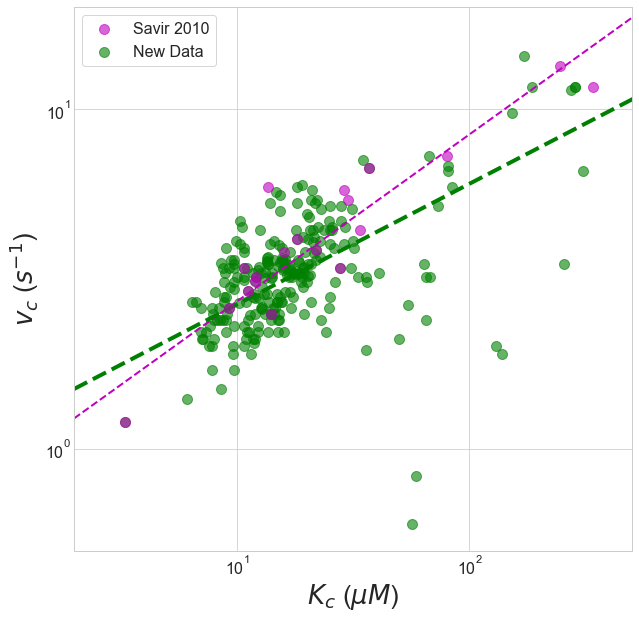

In [10]:
# Central correlation of Savir2010 is KC vs vC. 
# KC vs. vC correlation for all data rubiscos
KCs = np.log(raw_kin_df.KC)
vCs = np.log(raw_kin_df.vC)

exponent, prefactor, r2 = power_laws.fit_power_law_odr(KCs, vCs)

# Here we plot data from Savir separate from new data.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

# loglog scale
plt.xscale('log')
plt.yscale('log')

# Note - axes are reversed from the Savir paper so above the line = good.
plt.scatter(savir_df.KC, savir_df.vC, c='m', s=100, label='Savir 2010', alpha=0.6, zorder=10)
plt.scatter(nonsavir_df.KC, nonsavir_df.vC, c='g', s=100, alpha=0.6, label='New Data')

# Plot Savir's power law for Kc vs. Vc
# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs_savir = np.power(xs/1.32, 1.0/2.03)
projected_Vcs = np.power(xs, exponent)*prefactor

plt.plot(xs, projected_Vcs_savir, ls='--', c='m', lw=2)
plt.plot(xs, projected_Vcs, ls='--', c='g', lw=4)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=26)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

plt.savefig('fig3/fig3_vC_KC_corr.svg')
plt.savefig('fig3/fig3_vC_KC_corr.png', dpi=600)


plt.show()

In [11]:
all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
exps, pres, rs = power_laws.bootstrap_power_law_odr(
    all_FIs.KC, all_FIs.vC, xs_std=all_FIs.KC_SD, ys_std=all_FIs.vC_SD,
    fraction=0.9, rounds=10000)

conf_range = [2.5, 97.5]
pre_interval = np.percentile(pres, conf_range)
exp_interval = np.percentile(exps, conf_range)
rs_interval = np.percentile(rs, conf_range)

print(exp_interval)
print(pre_interval)
print(rs_interval)
print()

/usr/local/lib/python3.6/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/Users/abrahamflamholz/Documents/workspace/rubisco/notebooks/power_laws.py:131: RuntimeWarning: invalid value encountered in log
  exp, pre, r = fit_power_law_odr(np.log(xs_sub), np.log(ys_sub))


[0.26593714 0.46187938]
[0.90582877 1.52536649]
[0.36859751 0.7384661 ]



[0.90582877 1.52536649]
[0.26593714 0.46187938]


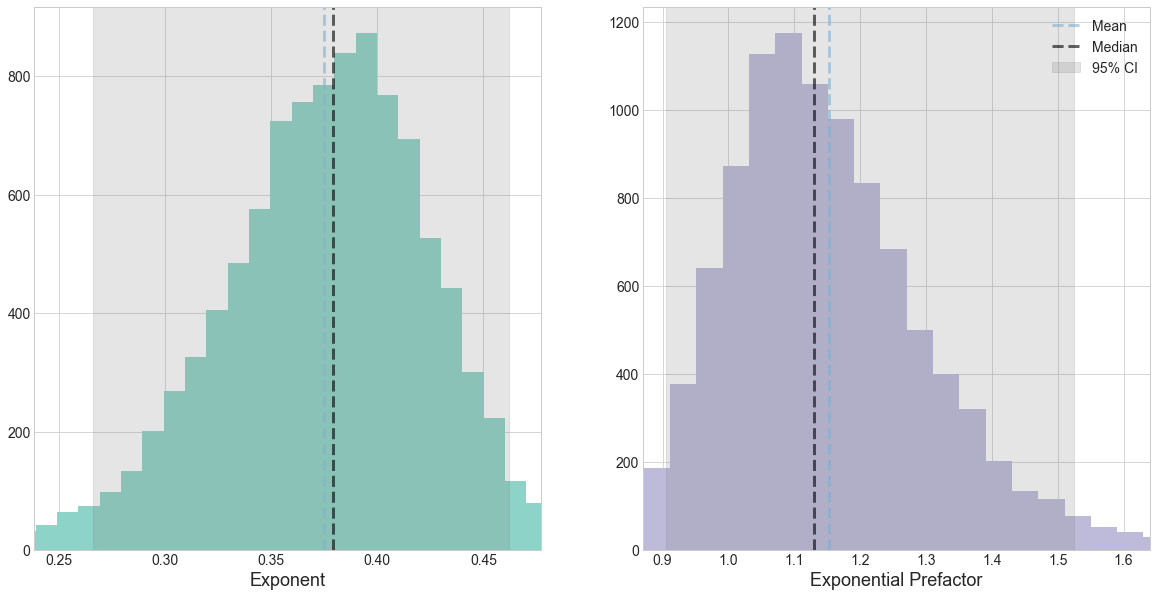

In [12]:
power_laws.plot_bootstrapped_range(exps, pres)

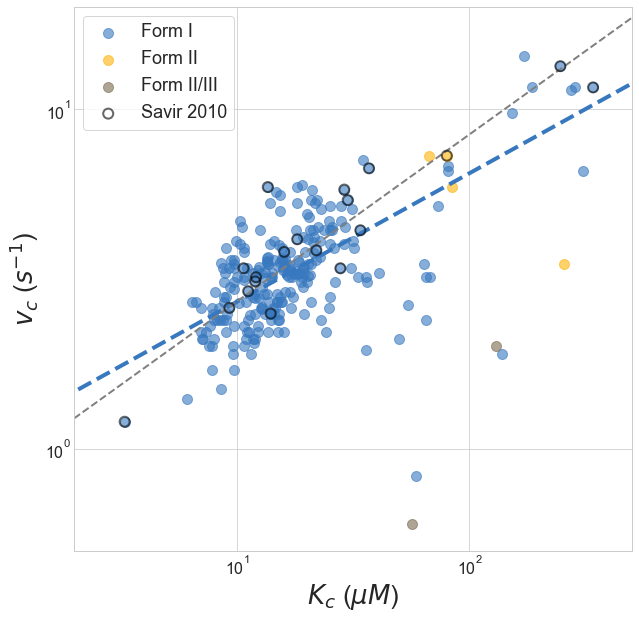

In [13]:
# Plot Kc vs. Vc coloring by RuBisCO form.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
    label = 'Form %s' % groups[group]
    c = named_colors[i]
    plt.scatter(gdf.KC, gdf.vC, c=c, s=100, label=label, alpha=0.6)

# Plot our own regression and CI - removed for now til I fix the plotting
xs = np.arange(1e0, 1e3, 0.01)
c = matplotlib.colors.rgb2hex(named_colors[0])
power_laws.plot_bootstrapped_ci(xs, exps, pres, figure=figure, color=c, plot_range=False, lw=4)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', c='grey', lw=2)

# Show savir data with an outline
plt.scatter(savir_df.KC, savir_df.vC, c='None', edgecolors='k',
            linewidths=2, s=100, label='Savir 2010', alpha=0.6, zorder=10)

plt.legend(loc=2, fontsize=18, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=26)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

plt.savefig('fig3/fig3_vC_KC_corr_FI.svg')
plt.savefig('fig3/fig3_vC_KC_corr_FI.png', dpi=600)

plt.show()

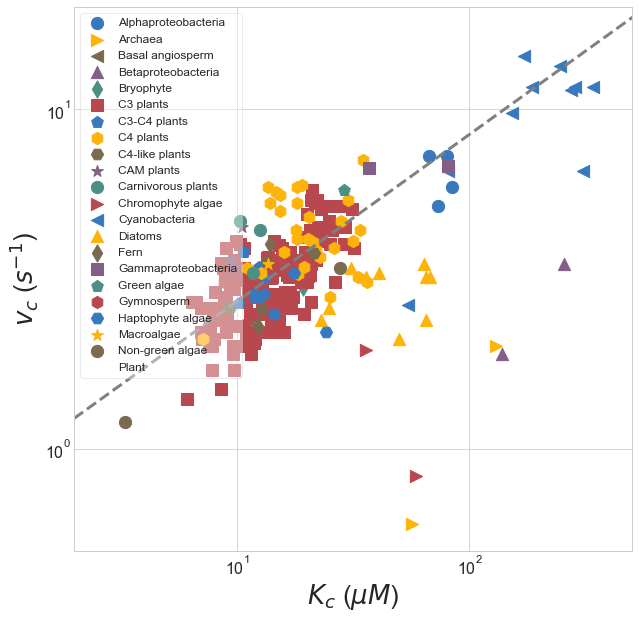

In [14]:
# Kc vs. Vc - show new data by taxonomic grouping of the organism. 
# Notice again the wide spread in photosynthetic bacteria being due to the
# very large deviations in measurements for the Rubrum FII enzyme.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

grouped_taxon = raw_kin_df.groupby('taxonomy')

for i, (group, gdf) in enumerate(grouped_taxon):
    marker = markers[i % len(markers)]
    # Hack here: since scatter accepts a list of colors, a tuple color specification won't work since it 
    # can be confused with a list. So I convert to hex for clarity.
    c = matplotlib.colors.rgb2hex(named_colors[i % len(named_colors)])
    plt.scatter(gdf.KC, gdf.vC, label=group, s=150, c=c, marker=marker)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', c='grey', lw=3)

leg = plt.legend(loc=2, fontsize=12, frameon=True)
leg.get_frame().set_alpha(0.4)

plt.xlabel('$K_c$ ($\mu M$)', fontsize=26)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

plt.show()